# Library

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Lambda

# Dataset
from: https://www.kaggle.com/datasets/shenba/time-series-datasets

In [15]:
data_frame = pd.read_csv('daily-minimum-temperatures-in-me.csv', parse_dates=['Date'])
data_frame = data_frame._convert(numeric=True)
data_frame_2 = data_frame.dropna()
data_frame_2.describe()

,Daily minimum temperatures
count,3647.000000
mean,11.186647
std,4.061671
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [3]:
print(data_frame_2.shape)
print(data_frame_2['Date'].min())
print(data_frame_2['Date'].max())

(3647, 2)
1981-01-01 00:00:00
1990-12-31 00:00:00


In [4]:
data_frame_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3647 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3647 non-null   datetime64[ns]
 1   Daily minimum temperatures  3647 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 85.5 KB


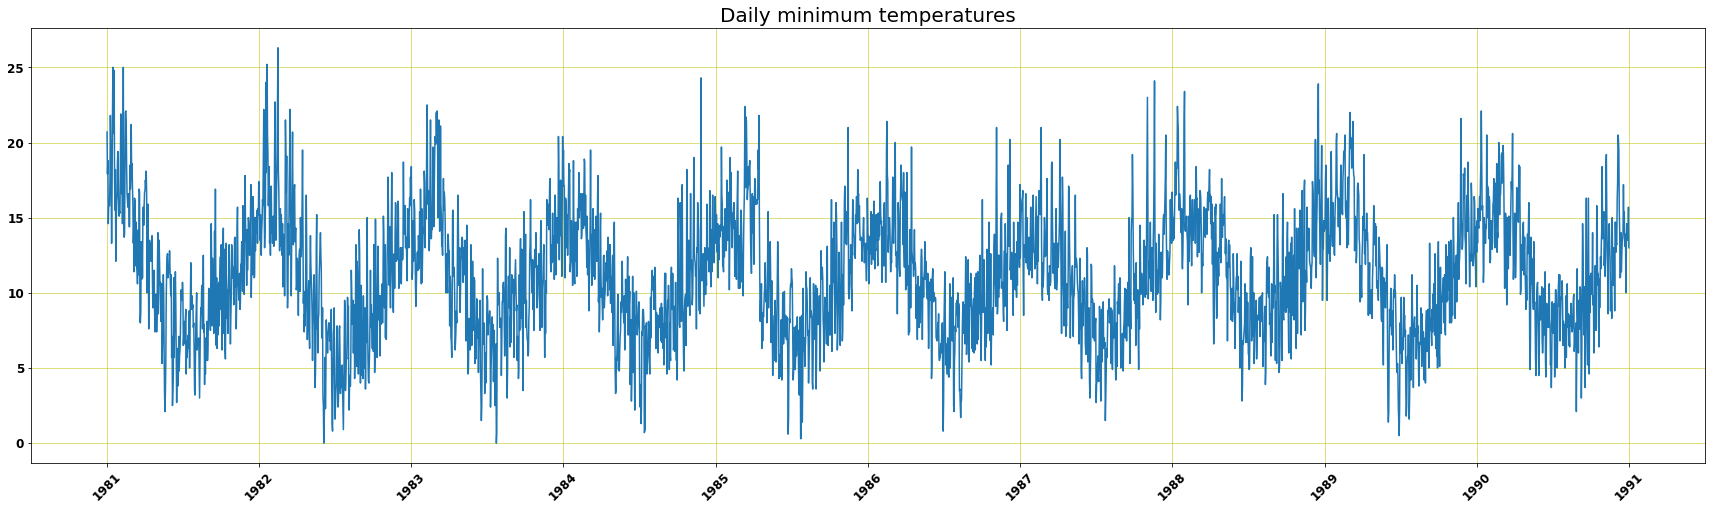

In [16]:
plt.figure(figsize=(30,8))
plt.plot(data_frame_2['Date'], data_frame_2['Daily minimum temperatures'])
plt.title('Daily minimum temperatures',
          fontsize=20)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

In [4]:
data_frame_2.set_index('Date', inplace=True)
data_frame_2.sort_index(inplace=True)

# SPLITTING USING TIMESERIESSPLIT

In [5]:
tscv = TimeSeriesSplit(n_splits=4)

X = data_frame_2.drop(labels=['Daily minimum temperatures'],axis=1)
y = data_frame_2['Daily minimum temperatures']

for train_index, val_index in tscv.split(X):
  X_train, X_val = X.iloc[train_index, :], X.iloc[val_index,:]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [7]:
X_train.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1988-12-22', '1988-12-23', '1988-12-24', '1988-12-25',
               '1988-12-26', '1988-12-27', '1988-12-28', '1988-12-29',
               '1988-12-30', '1989-01-01'],
              dtype='datetime64[ns]', name='Date', length=2918, freq=None)

In [8]:
X_val.index

DatetimeIndex(['1989-01-02', '1989-01-03', '1989-01-04', '1989-01-05',
               '1989-01-06', '1989-01-07', '1989-01-08', '1989-01-09',
               '1989-01-10', '1989-01-11',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=729, freq=None)

2918 (0.8) || 729 (0.2)

# Transform to Windowed Format

In [6]:
def windowed_dataset(series, window_size=100, batch_size=64, shuffle_buffer=1000):
	dataset = tf.data.Dataset.from_tensor_slices(series)
	dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
	dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
	dataset = dataset.shuffle(shuffle_buffer)
	dataset = dataset.map(lambda window: (window[:-1], window[-1]))
	dataset = dataset.batch(batch_size).prefetch(1)
	return dataset

In [7]:
train_set = windowed_dataset(y_train)
val_set = windowed_dataset(y_val)

# Build Model

In [8]:
model = Sequential()
model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),
                    input_shape=[None]))
model.add(LSTM(60))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 60)                14880     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 8)                 488       
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 15,409
Trainable params: 15,409
Non-traina

# Calculating Max_MAE

In [9]:
#menghitung 10% dari skala data
maximum = max(y)
minimum = min(y)
maximum_mae = (maximum-minimum)*0.1
print(maximum_mae)

2.6300000000000003


# Build Custom Callback

In [10]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('mae') <= maximum_mae*0.9):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

early_stopping = EarlyStopping()

# Compiling and Fitting Model

In [11]:
model.compile(loss=tf.keras.losses.Huber(),
              # optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9),
              metrics=["mae"])
history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=30,
                    verbose=2,
                    callbacks=[[early_stopping]])

Epoch 1/30
45/45 - 10s - loss: 10.2475 - mae: 10.7467 - val_loss: 9.9315 - val_mae: 10.4310 - 10s/epoch - 212ms/step
Epoch 2/30
45/45 - 1s - loss: 9.9043 - mae: 10.4033 - val_loss: 9.5550 - val_mae: 10.0542 - 840ms/epoch - 19ms/step
Epoch 3/30
45/45 - 1s - loss: 9.5070 - mae: 10.0061 - val_loss: 9.0891 - val_mae: 9.5878 - 954ms/epoch - 21ms/step
Epoch 4/30
45/45 - 1s - loss: 8.9180 - mae: 9.4164 - val_loss: 8.3447 - val_mae: 8.8412 - 789ms/epoch - 18ms/step
Epoch 5/30
45/45 - 1s - loss: 7.9224 - mae: 8.4195 - val_loss: 7.0171 - val_mae: 7.5139 - 935ms/epoch - 21ms/step
Epoch 6/30
45/45 - 1s - loss: 6.0648 - mae: 6.5561 - val_loss: 4.4150 - val_mae: 4.8983 - 782ms/epoch - 17ms/step
Epoch 7/30
45/45 - 1s - loss: 3.2562 - mae: 3.7296 - val_loss: 2.2513 - val_mae: 2.7104 - 832ms/epoch - 18ms/step
Epoch 8/30
45/45 - 1s - loss: 2.3205 - mae: 2.7807 - val_loss: 2.1018 - val_mae: 2.5613 - 805ms/epoch - 18ms/step
Epoch 9/30
45/45 - 1s - loss: 2.1484 - mae: 2.6071 - val_loss: 1.8186 - val_mae: 2

# PLOT MAE dan LOSS

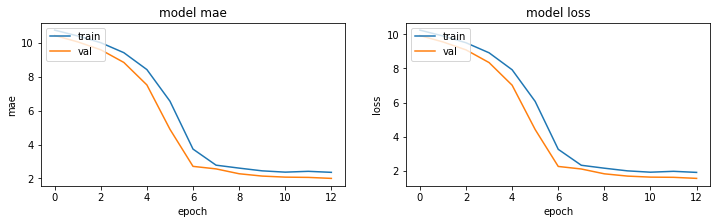

In [12]:
f = plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()